In [1]:
import pandas as pd

pi = pd.read_csv("../tidy/forcens_sp_r_wsst.csv")
lgm = pd.read_csv("../tidy/lgm_sp_r_wsst.csv")

## get the columns that are in both datasets
cols = pi.columns.intersection(lgm.columns)
## drops lat and lon in cols
cols = cols.drop(["Latitude", "Longitude", "SST"])
## put SST to the first column
cols = cols.insert(0, "SST")

pi = pi[cols]
lgm = lgm[cols]

len(pi.columns) == len(lgm.columns)

## fill na with 0
pi = pi.fillna(0)
lgm = lgm.fillna(0)

In [2]:
### randomly resample assemblage (one row) from LGM/PI
### and 1) compare compositional similarity
### and 2) calculate SST difference

## square chord distance
def scd(x, y):
    """
    squared chord distance to represent dissimilarity between
    the communities in different time. SCD ranges from 0 to 2, with
    0 meaning identical, and 2 most different.
    
    :parameter
    x: assemblage in numpy array
    y: assemblage in numpy array

    Example
    x = np.array([sp1, sp2, ..., sp_n])
    y = np.arra([sp1, sp2, ..., sp_n])
    scd(x, y)
    """

    x_sqrt = np.sqrt(x)
    y_sqrt = np.sqrt(y)
    scd = np.sum(np.square(x_sqrt - y_sqrt))

    return scd

## calculate Bray-Curtis dissimilarity
## and chord distance using scipy
from scipy.spatial import distance
import numpy as np

sample_size = 20000

dissim_bc, dissim_scd, dsst = [], [],[]
for i in range(sample_size):
    ## randomly sample one row from LGM
    lgm_sample = lgm.sample(1)
    ## randomly sample one row from PI
    pi_sample = pi.sample(1)
        
    lgm_sst_sample = lgm_sample.iloc[:, 0].to_numpy()[0]
    lgm_sp_sample = lgm_sample.iloc[:, 1:].to_numpy()[0]
    
    pi_sst_sample = pi_sample.iloc[:, 0].to_numpy()[0]
    pi_sp_sample = pi_sample.iloc[:, 1:].to_numpy()[0]

    
    dissim_bc.append(distance.braycurtis(lgm_sp_sample, pi_sp_sample))
    dissim_scd.append(scd(lgm_sp_sample, pi_sp_sample))
    dsst.append(np.abs(lgm_sst_sample - pi_sst_sample))
    

## convert to one dataframe
df = pd.DataFrame({"dissim_bc": dissim_bc,
                     "dissim_scd": dissim_scd,
                       "dsst": dsst})

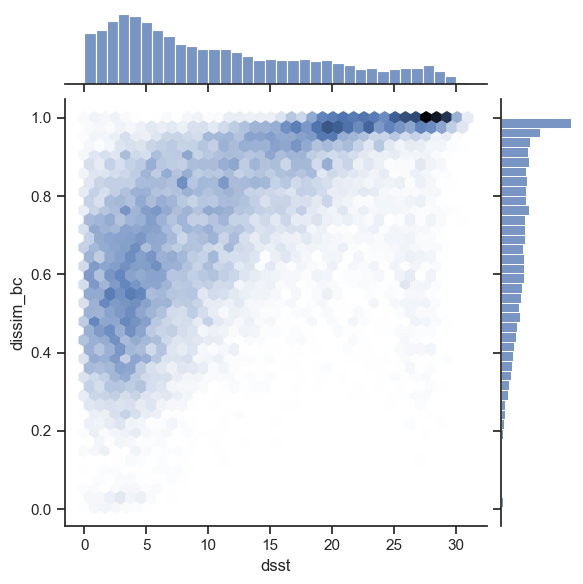

In [3]:
## plot using seaborn
import seaborn as sns
sns.set_theme(style="ticks")

sns.jointplot(x="dsst", y="dissim_bc", data=df, kind="hex")

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample

# Load your dataset
pi = pd.read_csv("../tidy/forcens_fg_a_wsst.csv")

# Define the bin width (1 degree SST bins)
bin_width = 1.0

# Create an array to store the fitted values for each bin
fitted_abundance_per_bin = []

# Iterate through SST bins
sst_min = pi['SST'].min()
sst_max = pi['SST'].max()
sst_bins = np.arange(sst_min, sst_max + bin_width, bin_width)

for sst_bin in sst_bins:
    # Filter data within the current bin
    bin_data = pi[(pi['SST'] >= sst_bin) & (pi['SST'] < sst_bin + bin_width)]

    if not bin_data.empty:
        # Number of bootstrap iterations for this bin
        n_bootstrap = 100  # You can adjust this number based on your needs

        # Create a DataFrame to store the fitted values for this bin
        bin_fitted_abundance_df = pd.DataFrame({'SST': bin_data['SST']})

        for i in range(n_bootstrap):
            # Create a bootstrap sample for the current bin
            sample = resample(bin_data, replace=True)

            # Fit quantile regression for the current bin
            X = sample['SST']
            y = sample['Symbiont-barren Spinose']
            X = sm.add_constant(X)  # Add a constant (intercept) to the model
            model = sm.QuantReg(y, X)
            result = model.fit(q=0.95)  # Fit for the 95th percentile

            # Predict abundance values for the original 'sst' values in this bin
            predicted_abundance = result.predict(X)

            # Store the predicted values in the DataFrame for this bin
            bin_fitted_abundance_df[f'bootstrap_{i+1}'] = predicted_abundance

        # Append the DataFrame for this bin to the list
        fitted_abundance_per_bin.append(bin_fitted_abundance_df)

# Now, 'fitted_abundance_per_bin' is a list of DataFrames, each containing fitted abundance values for a 1-degree SST bin.


ValueError: cannot reindex on an axis with duplicate labels

<Axes: xlabel='SST'>

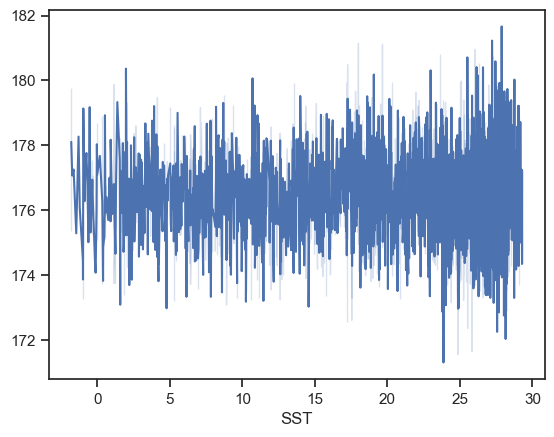

In [14]:
## get mean and sd of the fitted abundance
fitted_abundance = np.array(fitted_abundance)
mean_abundance = np.mean(fitted_abundance, axis=0)
sd_abundance = np.std(fitted_abundance, axis=0)

## plot the mean and sd vs SST
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')

sns.lineplot(x=pi["SST"], y=mean_abundance)
#plt.fill_between(pi["SST"], mean_abundance-sd_abundance, mean_abundance+sd_abundance, alpha=0.5)